---

# Notebook : Entraînement et sélection des modèles pour la prédiction du Nutri-Score

**Objectifs :**
1. Entraîner six modèles pour identifier les deux meilleurs en termes de prédiction de `nutriscore_grade`.
2. Utiliser une fraction de 10% pour chaque entraînement afin de limiter le risque de surapprentissage.
3. Comparer les performances des modèles avec une visualisation graphique, puis sélectionner les deux meilleurs pour des étapes d'optimisation avancées.
4. Afficher les paramètres statistiques (intercept et coefficients) pour chaque modèle lorsque cela est possible.

---

## Étape 1 : Importer les bibliothèques nécessaires et charger les données


In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import joblib
import os

---

## Étape 2 : Charger les données et préparer les variables


In [8]:
# Charger les données
file_path = 'note-books/phase_2_training/04_correlation_analysis/data_final_features.csv'
df = pd.read_csv(file_path)

# Encoder `nutriscore_grade` en valeurs numériques
df['nutriscore_grade_encoded'] = df['nutriscore_grade'].map({'a': 0, 'b': 1, 'c': 2, 'd': 3, 'e': 4})

# Préparer les variables explicatives et la cible en utilisant les colonnes sélectionnées
X = df[['fat_100g', 'saturated-fat_100g', 'energy-kcal_100g', 'sugars_100g', 'salt_100g', 'proteins_100g']]
y = df['nutriscore_grade_encoded']

# Fractionner les données : 90% pour validation croisée, 10% pour l'entraînement de chaque modèle
X_remaining, X_train, y_remaining, y_train = train_test_split(X, y, test_size=0.1, random_state=42)

---

## Étape 3 : Définir les modèles et les grilles d’hyperparamètres

In [9]:
# Liste des modèles et des hyperparamètres
models = [
    ('Linear Regression', LinearRegression(), {'fit_intercept': [True, False]}),
    ('Ridge', Ridge(), {'alpha': [0.1, 1.0, 10.0, 100.0]}),
    ('Lasso', Lasso(), {'alpha': [0.01, 0.1, 1.0, 10.0]}),
    ('Decision Tree', DecisionTreeRegressor(), {'max_depth': [5, 10, 15, 20]}),
    ('Random Forest', RandomForestRegressor(), {
        'n_estimators': [50, 100],
        'max_depth': [None, 10]
    }),
    ('Gradient Boosting', GradientBoostingRegressor(), {
        'n_estimators': [50, 100],
        'learning_rate': [0.01, 0.1, 0.2]
    })
]

---

## Étape 4 : Entraîner les modèles avec `GridSearchCV` et afficher les statistiques

In [10]:
# Initialiser une liste pour stocker les résultats
results = []

for model_name, model, param_grid in models:
    print(f"Entraînement de {model_name} en cours...")

    # Initialiser GridSearchCV pour la recherche d’hyperparamètres
    grid_search = GridSearchCV(
        model, param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1
    )
    
    # Entraîner le modèle
    grid_search.fit(X_train, y_train)

    # Meilleurs paramètres et score
    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(X_remaining)
    mse = mean_squared_error(y_remaining, y_pred)
    r2 = r2_score(y_remaining, y_pred)

    # Afficher les paramètres statistiques (si applicable)
    if hasattr(best_model, 'intercept_'):
        print(f"Intercept pour {model_name} : {best_model.intercept_}")
    if hasattr(best_model, 'coef_'):
        print(f"Coefficients pour {model_name} : {best_model.coef_}")

    # Calculer les résidus (écarts entre valeurs réelles et prédites)
    residuals = y_remaining - y_pred
    print(f"Aperçu des résidus pour {model_name} :\n{residuals.head()}\n")

    # Stocker les résultats
    results.append({
        'Modèle': model_name,
        'Best Params': grid_search.best_params_,
        'MSE': mse,
        'R²': r2,
        'Model Object': best_model
    })

    print(f"{model_name} terminé. Meilleur MSE : {mse}, R² : {r2}")
    print("-" * 40)

Entraînement de Linear Regression en cours...
Intercept pour Linear Regression : 1.2649981546523408
Coefficients pour Linear Regression : [ 0.02516221  0.06690188  0.00137401  0.01671599  0.33299556 -0.04060022]
Aperçu des résidus pour Linear Regression :
147259    0.643179
63966    -0.415476
153664   -0.938182
126983   -0.608761
53030     0.166628
Name: nutriscore_grade_encoded, dtype: float64

Linear Regression terminé. Meilleur MSE : 1.0700856385352429, R² : 0.40576994793426
----------------------------------------
Entraînement de Ridge en cours...
Intercept pour Ridge : 1.2651938017277073
Coefficients pour Ridge : [ 0.02516728  0.06689999  0.00137392  0.01671164  0.33256496 -0.04058869]
Aperçu des résidus pour Ridge :
147259    0.643598
63966    -0.415486
153664   -0.938594
126983   -0.609053
53030     0.166797
Name: nutriscore_grade_encoded, dtype: float64

Ridge terminé. Meilleur MSE : 1.0700920623293058, R² : 0.4057663807323997
----------------------------------------
Entraîneme

---

## Étape 5 : Comparer et visualiser les performances

Nous trions les modèles par MSE et utilisons un graphique pour comparer leurs performances afin de choisir les deux meilleurs modèles.

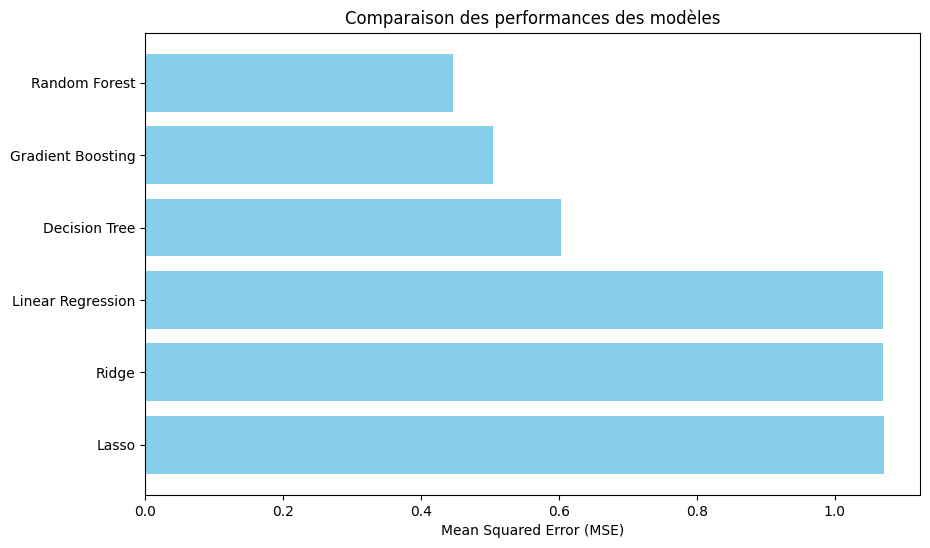

In [11]:
# Convertir les résultats en DataFrame et trier par MSE
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='MSE').reset_index(drop=True)

# Visualisation des MSE pour chaque modèle
plt.figure(figsize=(10, 6))
plt.barh(results_df['Modèle'], results_df['MSE'], color='skyblue')
plt.xlabel('Mean Squared Error (MSE)')
plt.title('Comparaison des performances des modèles')
plt.gca().invert_yaxis()
plt.show()

# Sélection des deux meilleurs modèles
top_models = results_df.nsmallest(2, 'MSE')

---

## Étape 6 : Sauvegarder les deux meilleurs modèles pour des optimisations ultérieures

In [12]:
# Définir le dossier de sortie
output_folder = 'note-books/phase_2_training/06_model_selection_comparison'

# Créer le dossier s'il n'existe pas
os.makedirs(output_folder, exist_ok=True)

# Sauvegarder les deux meilleurs modèles
for i in range(2):
    model_name = top_models.iloc[i]['Modèle']
    best_model = top_models.iloc[i]['Model Object']
    model_path = os.path.join(output_folder, f'{model_name.replace(" ", "_")}_optimized.joblib')
    joblib.dump(best_model, model_path)

print(f"\nLes deux meilleurs modèles optimisés et les résultats de performance ont été sauvegardés dans le dossier : {output_folder}")


Les deux meilleurs modèles optimisés et les résultats de performance ont été sauvegardés dans le dossier : note-books/phase_2_training/06_model_selection_comparison



---

### Explication des étapes

1. **Fractionnement des données** : Utilisation de 10% des données pour l’entraînement, réduisant le risque de surapprentissage.
2. **Entraînement de six modèles** : Chaque modèle est optimisé avec `GridSearchCV` pour trouver les meilleurs hyperparamètres.
3. **Paramètres statistiques** : Pour chaque modèle, nous affichons les statistiques disponibles (intercept et coefficients) afin de mieux comprendre les effets des variables.
4. **Comparaison visuelle** : Utilisation d’un graphique pour comparer les performances et identifier les deux meilleurs modèles en termes de MSE.
5. **Sauvegarde des meilleurs modèles** : Sauvegarde des deux modèles les plus performants pour une optimisation future.

---

### Résumé

Dans ce notebook, nous avons :
1. Chargé et préparé les données en sélectionnant les variables pertinentes.
2. Défini et entraîné six modèles avec des hyperparamètres adaptés.
3. Comparé visuellement les performances pour identifier les deux modèles les plus performants.
4. Sauvegardé ces deux modèles pour des étapes d’optimisation et d’entraînement approfondis.
5. Affiché les paramètres statistiques pour chaque modèle lorsque disponibles (intercept, coefficients, résidus).

Ce workflow met en avant les étapes clés pour sélectionner les modèles optimaux pour la prédiction de `nutriscore_grade`, avec une comparaison claire et des statistiques pour mieux comprendre les performances.